<a href="https://colab.research.google.com/github/JoseManuel1007/Proyecto2/blob/main/analisis_baterias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Carpeta de datos: /content/drive/MyDrive/Proyecto2/data
Modelos de batería disponibles:
- B0047
- B0045
- B0048
- B0046
- B0043
- B0032
- B0039
- B0040
- B0029
- B0028
- B0042
- B0034
- B0038
- B0033
- B0030
- B0041
- B0027
- B0044
- B0036
- B0025
- B0026
- B0031
- B0049
- B0050
- B0052
- B0051
- B0006
- B0005
- B0007
- B0018
- B0053
- B0054
- B0056
- B0055

Ingrese el modelo de batería (por ejemplo, B0005): B0005

La batería B0005 tiene 616 ciclos registrados.
Ingrese el número de ciclo que desea analizar: 200

Cargando archivo: 05320.csv


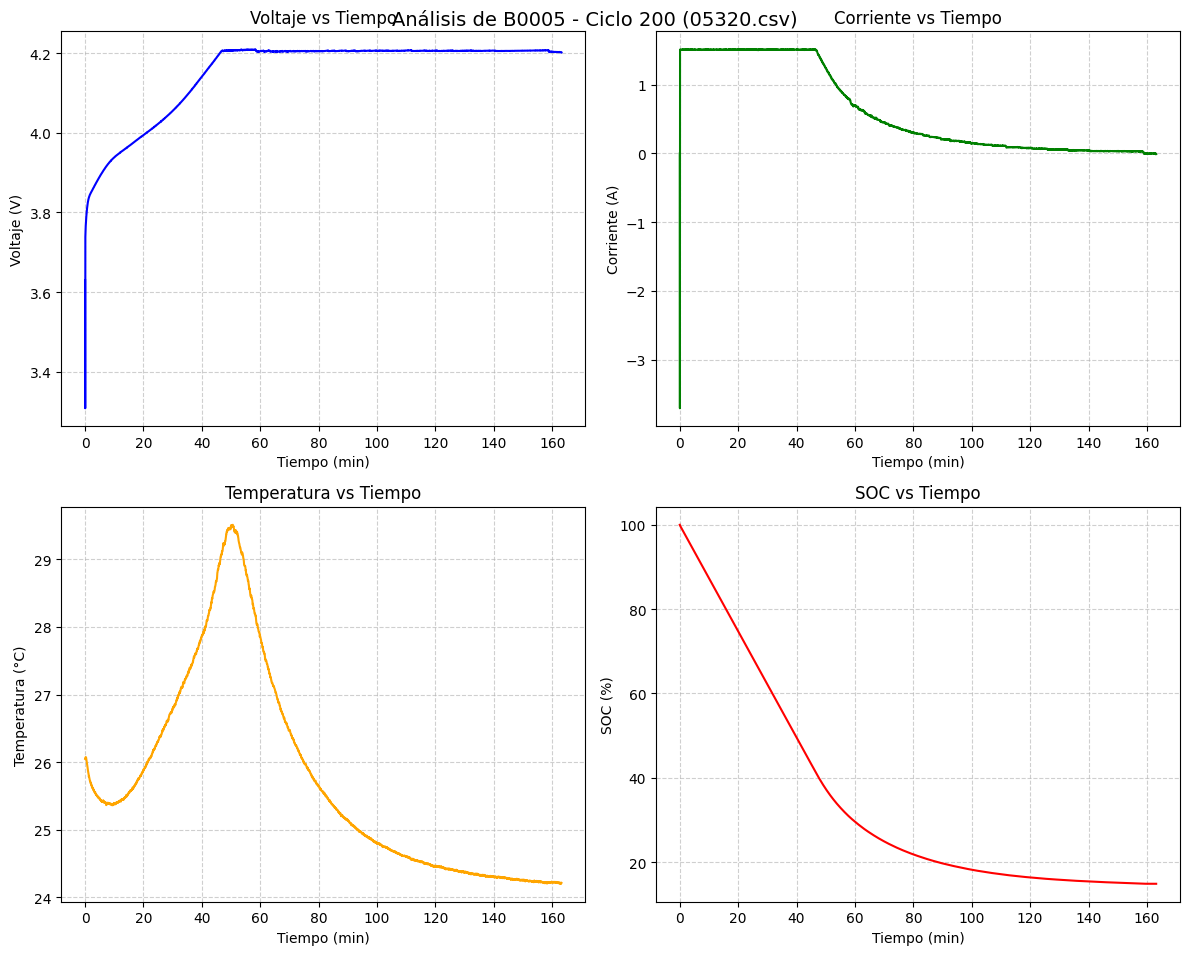

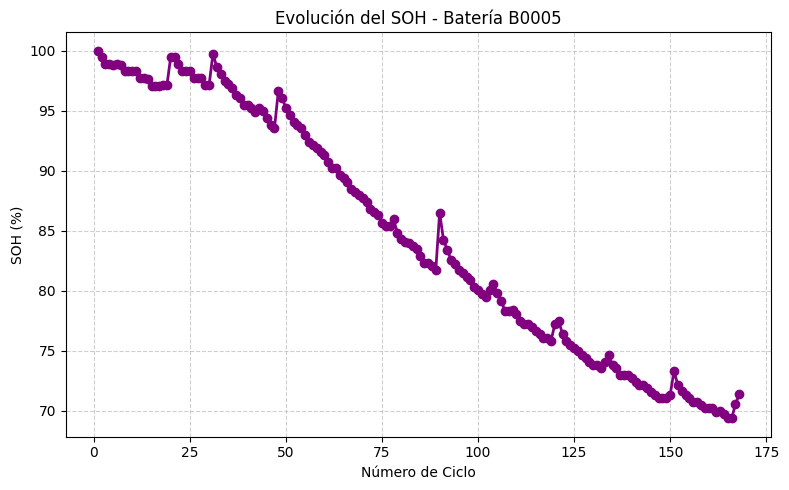


Análisis completado correctamente.

=== Calculadora de almacenamiento de energía ===
Ingrese el ID de batería (ej. B0047): B0047
Ingrese la energía deseada (kWh): 34
Tipo de conexión (serie o paralelo): serie

--- Cálculo para B0047 ---
Tipo de conexión: Serie
Voltaje nominal por celda: 3.7 V
Capacidad nominal por celda: 2.0 Ah
Energía por celda: 7.40 Wh
Energía deseada: 34000 Wh (34.0 kWh)
Número de celdas requeridas: 4595
Voltaje total del banco: 17000.00 V
Capacidad total del banco: 2.00 Ah

=== Dimensionamiento del Sistema de Baterías ===
Seleccione la aplicación del sistema:
1. Vehículo eléctrico
2. Vivienda (BESS)
Ingrese el número de la opción: 1

Ingrese la energía requerida (kWh): 39

Seleccione el modelo de celda:
- B0005
- B0006
- B0007
- B0018
Ingrese el ID de la celda (ej. B0005): B0005

--- Resultados del Dimensionamiento ---
Aplicación: vehículo eléctrico
Energía requerida: 39.00 kWh
Celda seleccionada: B0005
Energía por celda: 7.40 Wh
Número total de celdas: 5270
Peso 

In [ ]:
# ==============================================================
# UNIVERSIDAD DE ANTIOQUIA
# COMPUTACIÓN NUMÉRICA - PROYECTO 2
# ANÁLISIS DE DATOS DE BATERÍAS - VERSIÓN PARA GOOGLE COLAB
# ==============================================================

# --------------------------------------------------------------
# Este script analiza datos experimentales de baterías de litio,
# calcula el SOC (State of Charge) y el SOH (State of Health),
# y genera gráficos de voltaje, corriente, temperatura y capacidad.
#
# Adaptado para ejecutarse en Google Colab con archivos almacenados
# en Google Drive:
#   - metadata.csv
#   - carpeta 'data' con los archivos CSV de datos por ciclo
# --------------------------------------------------------------

# ==============================================================
# 1. MONTAJE DE GOOGLE DRIVE Y CONFIGURACIÓN DE RUTAS
# ==============================================================

from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/Proyecto2"
METADATA_PATH = os.path.join(BASE_PATH, "metadata.csv")
DATA_FOLDER = os.path.join(BASE_PATH, "data")  # <- carpeta con los CSV

# Verificar si la carpeta de datos existe
if not os.path.exists(DATA_FOLDER):
    raise FileNotFoundError(f"No se encontró la carpeta de datos: {DATA_FOLDER}")

print(f"Carpeta de datos: {DATA_FOLDER}")

# ==============================================================
# 2. (SECCIÓN ELIMINADA: DESCOMPRESIÓN DE ARCHIVOS DE DATOS)
#    El código ahora lee directamente de la carpeta 'data'
# ==============================================================


# ==============================================================
# 3. CARGA DE METADATA
# ==============================================================

metadata = pd.read_csv(METADATA_PATH)

# Mostrar modelos de batería disponibles
modelos = metadata['battery_id'].unique()
print("Modelos de batería disponibles:")
for modelo in modelos:
    print("-", modelo)

# ==============================================================
# 4. SELECCIÓN DE BATERÍA Y CICLO
# ==============================================================

bateria = input("\nIngrese el modelo de batería (por ejemplo, B0005): ").strip()
bateria_data = metadata[metadata['battery_id'] == bateria].reset_index(drop=True)

if bateria_data.empty:
    raise ValueError(f"No se encontró información para la batería {bateria}")

print(f"\nLa batería {bateria} tiene {len(bateria_data)} ciclos registrados.")
indice = int(input("Ingrese el número de ciclo que desea analizar: "))

if indice < 1 or indice > len(bateria_data):
    raise ValueError("Número de ciclo fuera de rango.")

filename = bateria_data.loc[indice - 1, 'filename']
file_path = os.path.join(DATA_FOLDER, filename)

# Verificar si el archivo de datos existe
if not os.path.exists(file_path):
    raise FileNotFoundError(f"No se encontró el archivo {filename} en {DATA_FOLDER}")

print(f"\nCargando archivo: {filename}")
df = pd.read_csv(file_path)

# ==============================================================
# 5. FUNCIONES DE CÁLCULO
# ==============================================================

def calcular_soc(df, capacidad_nominal=2.0):
    """Calcula el SOC (%) con base en corriente y tiempo."""
    df['Time_hr'] = df['Time'] / 3600.0
    df['Ah_descargados'] = np.cumsum(df['Current_measured'].abs() * np.gradient(df['Time_hr']))
    df['SOC (%)'] = 100 * (1 - df['Ah_descargados'] / capacidad_nominal)
    df['SOC (%)'] = df['SOC (%)'].clip(lower=0)
    return df


def calcular_soh(metadata_bateria):
    """Calcula el SOH (%) para los ciclos de una batería usando la capacidad."""
    discharge_data = metadata_bateria[metadata_bateria['type'] == 'discharge'].copy()
    discharge_data['Capacity'] = pd.to_numeric(discharge_data['Capacity'], errors='coerce')
    discharge_data = discharge_data.dropna(subset=['Capacity']).reset_index(drop=True)

    if discharge_data.empty:
        raise ValueError("No hay datos de descarga disponibles para calcular el SOH.")

    cap_inicial = discharge_data['Capacity'].iloc[0]
    discharge_data['SOH (%)'] = (discharge_data['Capacity'] / cap_inicial) * 100
    discharge_data['Cycle'] = range(1, len(discharge_data) + 1)
    return discharge_data

# ==============================================================
# 6. CÁLCULO DE SOC Y SOH
# ==============================================================

df = calcular_soc(df)
soh_data = calcular_soh(bateria_data)

# ==============================================================
# 7. GRAFICAR RESULTADOS
# ==============================================================

plt.figure(figsize=(12, 10))

# Voltaje
plt.subplot(2, 2, 1)
plt.plot(df['Time'] / 60, df['Voltage_measured'], color='blue')
plt.title('Voltaje vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('Voltaje (V)')
plt.grid(True, linestyle='--', alpha=0.6)

# Corriente
plt.subplot(2, 2, 2)
plt.plot(df['Time'] / 60, df['Current_measured'], color='green')
plt.title('Corriente vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('Corriente (A)')
plt.grid(True, linestyle='--', alpha=0.6)

# Temperatura
plt.subplot(2, 2, 3)
plt.plot(df['Time'] / 60, df['Temperature_measured'], color='orange')
plt.title('Temperatura vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('Temperatura (°C)')
plt.grid(True, linestyle='--', alpha=0.6)

# SOC
plt.subplot(2, 2, 4)
plt.plot(df['Time'] / 60, df['SOC (%)'], color='red')
plt.title('SOC vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('SOC (%)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle(f'Análisis de {bateria} - Ciclo {indice} ({filename})', fontsize=14, y=0.95)
plt.tight_layout()
plt.show()

# SOH vs Ciclo
plt.figure(figsize=(8, 5))
plt.plot(soh_data['Cycle'], soh_data['SOH (%)'], marker='o', linewidth=2, color='purple')
plt.title(f'Evolución del SOH - Batería {bateria}')
plt.xlabel('Número de Ciclo')
plt.ylabel('SOH (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nAnálisis completado correctamente.")

# ==============================================================
# 8. CALCULADORA DE ALMACENAMIENTO DE ENERGÍA
# ==============================================================

baterias = {
    "B0005": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0006": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0007": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0018": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0029": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0030": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0047": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0048": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
}

def calcular_celdas(bateria, energia_kwh, tipo_conexion):
    if bateria not in baterias:
        print("Error: la batería seleccionada no está en la base de datos.")
        return

    datos = baterias[bateria]
    energia_celda_Wh = datos["V_nominal"] * datos["Capacidad_Ah"]
    energia_deseada_Wh = energia_kwh * 1000

    n_celdas = energia_deseada_Wh / energia_celda_Wh
    if tipo_conexion == "serie":
        voltaje_total = n_celdas * datos["V_nominal"]
        capacidad_total = datos["Capacidad_Ah"]
    elif tipo_conexion == "paralelo":
        voltaje_total = datos["V_nominal"]
        capacidad_total = n_celdas * datos["Capacidad_Ah"]
    else:
        print("Error: tipo de conexión no válido. Use 'serie' o 'paralelo'.")
        return

    print(f"\n--- Cálculo para {bateria} ---")
    print(f"Tipo de conexión: {tipo_conexion.capitalize()}")
    print(f"Voltaje nominal por celda: {datos['V_nominal']} V")
    print(f"Capacidad nominal por celda: {datos['Capacidad_Ah']} Ah")
    print(f"Energía por celda: {energia_celda_Wh:.2f} Wh")
    print(f"Energía deseada: {energia_deseada_Wh:.0f} Wh ({energia_kwh} kWh)")
    print(f"Número de celdas requeridas: {n_celdas:.0f}")
    print(f"Voltaje total del banco: {voltaje_total:.2f} V")
    print(f"Capacidad total del banco: {capacidad_total:.2f} Ah")

# ==============================================================
# 9. EJECUCIÓN DE LA CALCULADORA
# ==============================================================

print("\n=== Calculadora de almacenamiento de energía ===")
bateria_calc = input("Ingrese el ID de batería (ej. B0047): ").strip()
energia_kwh = float(input("Ingrese la energía deseada (kWh): "))
tipo_conexion = input("Tipo de conexión (serie o paralelo): ").strip().lower()

calcular_celdas(bateria_calc, energia_kwh, tipo_conexion)

# ==============================================================
# 10. MÓDULO DE DIMENSIONAMIENTO DEL SISTEMA DE BATERÍAS
# ==============================================================

def dimensionamiento_sistema():
    print("\n=== Dimensionamiento del Sistema de Baterías ===")
    print("Seleccione la aplicación del sistema:")
    print("1. Vehículo eléctrico")
    print("2. Vivienda (BESS)")

    opcion = input("Ingrese el número de la opción: ").strip()
    if opcion == "1":
        aplicacion = "vehículo eléctrico"
    elif opcion == "2":
        aplicacion = "vivienda"
    else:
        print("Opción no válida.")
        return

    energia_kwh = float(input("\nIngrese la energía requerida (kWh): "))

    baterias = {
        "B0005": {"V_nominal": 3.7, "Capacidad_Ah": 2.0, "Masa_kg": 0.045, "Densidad_Wh_kg": 164},
        "B0006": {"V_nominal": 3.6, "Capacidad_Ah": 2.0, "Masa_kg": 0.046, "Densidad_Wh_kg": 156},
        "B0007": {"V_nominal": 3.7, "Capacidad_Ah": 2.2, "Masa_kg": 0.047, "Densidad_Wh_kg": 173},
        "B0018": {"V_nominal": 3.7, "Capacidad_Ah": 1.9, "Masa_kg": 0.044, "Densidad_Wh_kg": 160}
    }

    print("\nSeleccione el modelo de celda:")
    for b in baterias.keys():
        print(f"- {b}")
    celda_id = input("Ingrese el ID de la celda (ej. B0005): ").strip().upper()

    if celda_id not in baterias:
        print("Celda no encontrada.")
        return

    celda = baterias[celda_id]

    energia_celda_Wh = celda["V_nominal"] * celda["Capacidad_Ah"]
    n_celdas = (energia_kwh * 1000) / energia_celda_Wh
    peso_total = n_celdas * celda["Masa_kg"]

    print("\n--- Resultados del Dimensionamiento ---")
    print(f"Aplicación: {aplicacion}")
    print(f"Energía requerida: {energia_kwh:.2f} kWh")
    print(f"Celda seleccionada: {celda_id}")
    print(f"Energía por celda: {energia_celda_Wh:.2f} Wh")
    print(f"Número total de celdas: {n_celdas:.0f}")
    print(f"Peso total estimado: {peso_total:.2f} kg")
    print(f"Densidad energética de la celda: {celda['Densidad_Wh_kg']} Wh/kg")

    tipo_config = input("\nSeleccione la configuración (serie/paralelo): ").strip().lower()

    if tipo_config == "serie":
        voltaje_total = n_celdas * celda["V_nominal"]
        capacidad_total = celda["Capacidad_Ah"]
    elif tipo_config == "paralelo":
        voltaje_total = celda["V_nominal"]
        capacidad_total = n_celdas * celda["Capacidad_Ah"]
    else:
        print("Configuración no válida. Se asumirá serie.")
        voltaje_total = n_celdas * celda["V_nominal"]
        capacidad_total = celda["Capacidad_Ah"]

    energia_total_Wh = voltaje_total * capacidad_total

    print("\n--- Parámetros Eléctricos del Sistema ---")
    print(f"Configuración: {tipo_config}")
    print(f"Voltaje total: {voltaje_total:.2f} V")
    print(f"Capacidad total: {capacidad_total:.2f} Ah")
    print(f"Energía total estimada: {energia_total_Wh/1000:.2f} kWh")

    comparar = input("\n¿Desea comparar con otra química? (s/n): ").strip().lower()
    if comparar == "s":
        print("\nSeleccione la segunda celda para comparar:")
        for b in baterias.keys():
            print(f"- {b}")
        celda_comp = input("Ingrese el ID de la segunda celda: ").strip().upper()

        if celda_comp not in baterias:
            print("Celda no encontrada.")
            return

        celda2 = baterias[celda_comp]
        energia_celda2_Wh = celda2["V_nominal"] * celda2["Capacidad_Ah"]
        n_celdas2 = (energia_kwh * 1000) / energia_celda2_Wh
        peso_total2 = n_celdas2 * celda2["Masa_kg"]

        print("\n--- Comparación entre químicas ---")
        print(f"{celda_id}: {peso_total:.2f} kg para {energia_kwh:.2f} kWh")
        print(f"{celda_comp}: {peso_total2:.2f} kg para {energia_kwh:.2f} kWh")
        diferencia = ((peso_total2 - peso_total) / peso_total) * 100
        print(f"Diferencia de peso: {diferencia:+.2f}%")

# ==============================================================
# 11. EJECUCIÓN DEL MÓDULO DE DIMENSIONAMIENTO
# ==============================================================

if __name__ == "__main__":
    dimensionamiento_sistema()